<a href="https://colab.research.google.com/github/winston1214/Paper-with-code/blob/master/VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision import utils
import torchvision

from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/논문/'

In [18]:
# trainset = datasets.STL10(root= path + 'data',split = 'train',download=True,transform=T.ToTensor())
trainset = datasets.CIFAR10(root= path + 'data',train=True,download=True,transform=T.ToTensor())
trainset, valset = torch.utils.data.random_split(trainset, [int(len(trainset)*0.8), int(len(trainset)*0.2)])
# testset = datasets.STL10(root = path+ ' data',split = 'test',download=True,transform = T.ToTensor())
testset = datasets.CIFAR10(root = path+ ' data',train=False,download=True,transform = T.ToTensor())
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


In [19]:
img,label = trainset[0]
print(img.shape)

torch.Size([3, 32, 32])


In [20]:
print(len(trainset))
print(len(testset))

40000
10000


In [21]:
## Normalization
train_meanRGB = [np.mean(x.numpy(),axis = (1,2)) for x,_ in trainset] # 채널별 평균
train_stdRGB = [np.std(x.numpy(),axis = (1,2)) for x,_ in trainset] # 채널별 std

train_meanR = np.mean([m[0] for m in train_meanRGB]) 
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])

train_stdR = np.mean([m[0] for m in train_stdRGB])
train_stdG = np.mean([m[1] for m in train_stdRGB])
train_stdB = np.mean([m[2] for m in train_stdRGB])

val_meanRGB = [np.mean(x.numpy(),axis=(1,2)) for x,_ in valset]
val_stdRGB = [np.std(x.numpy(),axis=(1,2)) for x,_ in valset]

val_meanR = np.mean([m[0] for m in val_meanRGB])
val_meanG = np.mean([m[1] for m in val_meanRGB])
val_meanB = np.mean([m[2] for m in val_meanRGB])

val_stdR = np.mean([s[0] for s in val_stdRGB])
val_stdG = np.mean([s[1] for s in val_stdRGB])
val_stdB = np.mean([s[2] for s in val_stdRGB])

print(f'train RGB : {train_meanR} {train_meanG} {train_meanB}')
print(f'val RGB : {val_meanR} {val_meanG} {val_meanB}')

train RGB : 0.49113139510154724 0.4820432662963867 0.4462270438671112
val RGB : 0.4924727976322174 0.4826190769672394 0.4477465748786926


In [22]:
train_transform = T.Compose([
                            #  T.Resize(256),
                            #  T.Lambda(lambda crops : torch.stack([T.ToTensor()(crop) for crop in crops])),
                             T.Normalize([train_meanR,train_meanG,train_meanB],[train_stdR,train_stdG,train_stdB])
])
trainset.transform = train_transform
valset.transform = train_transform

In [23]:
batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset,batch_size = batch_size,shuffle = True)
valloader = torch.utils.data.DataLoader(valset,batch_size = batch_size,shuffle = True)
testloader = torch.utils.data.DataLoader(testset,batch_size = batch_size)

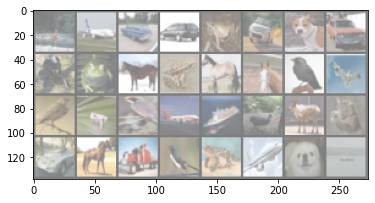

In [24]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
# print(classes[labels])

In [26]:
# int = output channel 개수
# M = max pooling layer

cfgs = {'VGG11' : [64, 'M', 128, 'M', 256, 256, 'M', 512,512, 'M',512,512,'M'],
    'VGG13' : [64,64, 'M', 128, 128, 'M', 256, 256, 'M', 512,512, 'M', 512,512,'M'],
    'VGG16' : [64,64, 'M', 128, 128, 'M', 256, 256,256, 'M', 512,512,512, 'M',512,512,512,'M'],
    'VGG19' : [64,64, 'M', 128, 128, 'M', 256, 256,256,256, 'M', 512,512,512,512, 'M',512,512,512,512,'M']}

In [38]:
# define VGGnet class
class VGG(nn.Module):
    def __init__(self, model, in_channels=3, num_classes=10, init_weights=True):
        super().__init__()
        self.in_channels = in_channels

        # create conv_layers corresponding to VGG type
        self.conv_layers = self.create_conv_laters(cfgs[model])

        self.fcs = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

        # weight initialization
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv_layers(x)
        # print(x.shape)
        x = x.view(x.size(0),-1)
        # print(x.shape)
        x = self.fcs(x)
        return x

    # defint weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    # define a function to create conv layer taken the key of VGG_type dict 
    def create_conv_laters(self, architecture):
        layers = []
        in_channels = self.in_channels # 3

        for x in architecture:
            if type(x) == int: # int means conv layer
                out_channels = x

                layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                     kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                           nn.BatchNorm2d(x),
                           nn.ReLU()]
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]
        
        return nn.Sequential(*layers)


In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [58]:
model = VGG('VGG19',in_channels=3,num_classes = 10,init_weights=True).to(device)
model = model.to(device)
print(model)

VGG(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), str

In [47]:
summary(model,input_size = (3,32,32),device = device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [61]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size = 10,gamma=0.1)
model = model.to(device)
print(device)

cuda


In [62]:
total_step = len(trainloader)
epoch = 100
best_val_acc = 0
loss_list = []
train_plt_list = []
for e in range(epoch):
    train_acc_list = []
    running_loss = 0

    model.train()
    for i,(images,labels) in tqdm(enumerate(trainloader)):
        images = images*0.99 + 1e-3
        images = images.type(torch.FloatTensor).to(device)
        labels = labels.to(device,dtype=torch.int64)

        optimizer.zero_grad()

        probs = model(images)
        loss = loss_func(probs,labels)

        loss.backward()
        print(loss.grad)
        
        optimizer.step()

        running_loss += loss.item()
        
        preds = torch.max(probs,1)[-1]
        preds = preds.cpu().detach().numpy()
        # probs = probs.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()
        
        # print('pred',pred)
        # print('label',labels)
        batch_acc = (labels == preds).mean()
        train_acc_list.append(batch_acc)
    loss_list.append(running_loss/total_step)
    train_acc = np.mean(train_acc_list)
    train_plt_list.append(train_acc)
    print(f'loss : {running_loss/total_step}, Train accuracy : {train_acc}')

    model.eval()
    val_acc_list = []
    val_plt_list = []
    with torch.no_grad():
        correct = 0
        total = 0

        for images,labels in valloader:
            images = images*0.99 + 1e-3
            images = images.type(torch.FloatTensor).to(device)
            labels = labels.to(device,dtype = torch.int64)
            probs = model(images)
            loss = loss_func(probs,labels)
            preds = torch.max(probs,1)[-1]
            preds = preds.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            batch_acc = (labels == preds).mean()
            val_acc_list.append(batch_acc)
        val_acc = np.mean(val_acc_list)
        val_plt_list.append(val_acc)
        print(f'validation acc : {val_acc}')
    scheduler.step()

0it [00:00, ?it/s]

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


KeyboardInterrupt: ignored

In [ ]:
plt.plot(loss_list)

In [ ]:
labels